# Finite Difference Method for the Black–Scholes PDE (European Call)

## 1. The Black–Scholes PDE

We consider the **Black–Scholes** equation for a non-dividend-paying asset \(S\):
$$
\frac{\partial V}{\partial t} 
\;=\; 
\frac{1}{2}\,\sigma^2\,S^2 \,\frac{\partial^2 V}{\partial S^2}
\;+\;
r\,S\,\frac{\partial V}{\partial S}
\;-\;
r\,V,
$$
where
- $V = V(S,t)$ is the option price,
- $\sigma$ is the volatility,
- $r$ is the risk-free interest rate,
- $0 \leq S \leq S_{\max}$ and $0 \leq t \leq T$.

For a **European Call** with strike $K$ and maturity $T$,
we have the **terminal condition** at $t = T$:
$$
V(S,T) = \max(S - K,\,0).
$$

## 2. Boundary Conditions

Since this is a **Call** option:
- At $S=0$:  
  $$
    V(0,t) \;=\; 0, 
    \quad 
    \text{(the call is worthless if the underlying is zero).}
  $$
- At $S=S_{\max}$ (a large value chosen so that it approximates $+\infty$):  
  $$
    V(S_{\max}, t) 
    \;\approx\;
    S_{\max} - K\,e^{-r\,(T - t)},
    \quad
    \text{(the option behaves almost like }S - K e^{-r\tau}\text{).}
  $$

## 3. Discretization in Space and Time

We define a **spatial grid** $S_i = i\,\Delta S$ for $i = 0,1,\dots,M$, where 
$\Delta S = \frac{S_{\max}}{M}$.  
We also define a **time grid** $t^n = n\,\Delta t$ for $n = 0,1,\dots,N$, where 
$\Delta t = \frac{T}{N}$.

Hence, we store the option value in a 2D array $V^n_i \approx V(S_i,\,t^n)$.

## 4. The $\theta$-Scheme

Let $\theta \in [0,1]$. We use a **$\theta$-scheme** (also called the 
$\theta$-method) in time, which generalizes:
- $\theta=0$: **Explicit** (Euler forward),
- $\theta=1$: **Fully Implicit** (Euler backward),
- $\theta=\tfrac12$: **Crank–Nicolson**.

In semi-discrete form, we write:
$$
\frac{V^{n+1}_i - V^n_i}{\Delta t}
\;=\;
\theta\,\mathcal{L}V^{n+1}
\;+\;
(1-\theta)\,\mathcal{L}V^n,
$$
where $\mathcal{L}$ is the spatial operator approximating 
$\frac12 \sigma^2 S^2\partial_{SS} + rS \partial_S - r$.

### Spatial Operator in Differences

At a grid point $S_i$, let
$$
a_i = \frac{1}{2}\,\sigma^2\,S_i^2 \frac{1}{\Delta S^2}
      \;-\;
      \frac{r\,S_i}{2\,\Delta S}, 
\quad
b_i = -\,\frac{\sigma^2\,S_i^2}{\Delta S^2} \;-\; r, 
\quad
c_i = \frac{1}{2}\,\sigma^2\,S_i^2 \frac{1}{\Delta S^2}
      \;+\;
      \frac{r\,S_i}{2\,\Delta S}.
$$
Then the spatial discretization often leads to a **tridiagonal** matrix \(A\) such that
$$
(\mathcal{L}V^n)_i \;\approx\;
a_i\,V^n_{i-1} + b_i\,V^n_i + c_i\,V^n_{i+1}.
$$

### Combined Time-Space Scheme

Putting it all together, we solve at each time step \(n\):
$$
\bigl(I - \theta\,\Delta t\,A\bigr)\,V^{n+1}
\;=\;
\bigl(I + (1-\theta)\,\Delta t\,A\bigr)\,V^n
\;+\;\text{(boundary corrections)},
$$
where $V^n$ is the vector $(V^n_1,\dots,V^n_{M-1})$ (the interior points, excluding boundaries).  
We also incorporate the known Dirichlet boundary values at $S=0$ and $S=S_{\max}$ in each time step to handle the PDE boundary conditions.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [4]:
def fdm_pricer(
    Smax: float,
    K: float,
    T: float,
    r: float,
    sigma: float,
    M: int,
    N: int,
    theta: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    dS = Smax / M
    dt = T / N
    S = np.linspace(0, Smax, M+1)
    a = 0.5*(sigma**2)*S[1:M]**2/dS**2 - 0.5*r*S[1:M]/dS
    b = - (sigma**2)*S[1:M]**2/dS**2
    c =  0.5*(sigma**2)*S[1:M]**2/dS**2 + 0.5*r*S[1:M]/dS
    A = np.diag(1+b) + np.diag(c[:-1], 1) + np.diag(a[1:], -1)
    V = [np.maximum(S - K, 0)]
    I = np.eye(M-1)
    LHS = np.linalg.inv(I - theta*dt*A)
    RHS = I + (1 - theta)*dt*A
    MAT = LHS @ RHS
    for j in range(N):
        Val = np.zeros(M+1)
        f = np.zeros(M-1)
        f[0] = a[0] * V[-1][0]
        f[-1] = c[-1] * V[-1][-1]
        Val[1:-1] = MAT @ V[-1][1:-1] + dt*f
        Val[-1] = S[-1] - K * np.exp(-r*(T - (j+1)*dt))
        V.append(Val)
    t_vals = np.linspace(0, T, N+1)
    
    return np.array(V), S, t_vals

def black_scholes_call(S: float, K: float, T: float, r: float, sigma: float) -> float:
    if T < 1e-14:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
def demo_plots(N_arg):
    thetas = [0.0, 1.0, 0.5]
    titles = ["Explicit", "Implicit", "Crank–Nicolson"]
    
    fig = plt.figure(figsize=(15, 4))
    
    for i, th in enumerate(thetas):
        Varr, S, t_vals = fdm_pricer(
            Smax=100.0, 
            K=50.0, 
            T=5/12, 
            r=0.05, 
            sigma=0.2, 
            M=100, 
            N=N_arg, 
            theta=th
        )
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.set_title(titles[i])
        ax.set_xlabel("Stock price S")
        ax.set_ylabel("Time")
        ax.set_zlabel("Option price")
        
        Tmesh, Smesh = np.meshgrid(t_vals, S)
        Z = Varr.T
        surf = ax.plot_surface(Smesh, Tmesh, Z, cmap='viridis')
        
    plt.tight_layout()
    plt.show()
        
def demo_convergence_rms():
    N_values = range(1000, 10001, 500)
    schemes = [
        ("Explicit", 0.0),
        ("Implicit", 1.0),
        ("Crank–Nicolson", 0.5)
    ]
    
    errors = {name: [] for (name, _) in schemes}
    for N_ in tqdm(N_values, desc="Computing RMSE for various N"):
        for (scheme_name, theta) in schemes:
            Varr, S, t_vals = fdm_pricer(
                Smax=100.0, K=50.0, T=5/12,
                r=0.05, sigma=0.2,
                M=100, N=N_,
                theta=theta
            )
            squared_errors = 0.0
            count = 0
            
            for i, t_ in enumerate(t_vals):
                tau = (5/12) - t_
                
                exact_vals = [black_scholes_call(s_, 50.0, tau, 0.05, 0.2) for s_ in S]
                diff = Varr[i, :] - exact_vals
    
                squared_errors += np.sum(diff**2)
                count += len(diff)
            
            rms_error = np.sqrt(squared_errors / count)
            errors[scheme_name].append(rms_error)
    
    plt.figure(figsize=(8, 5))
    for (scheme_name, _) in schemes:
        plt.plot(list(N_values), errors[scheme_name], marker='o', label=scheme_name)
    
    plt.xlabel("Number of time steps (N)")
    plt.ylabel("RMSE vs. Black–Scholes")
    plt.title("Convergence in RMSE (over (S, t) grid points)")
    plt.legend()
    plt.grid(True)
    plt.show()

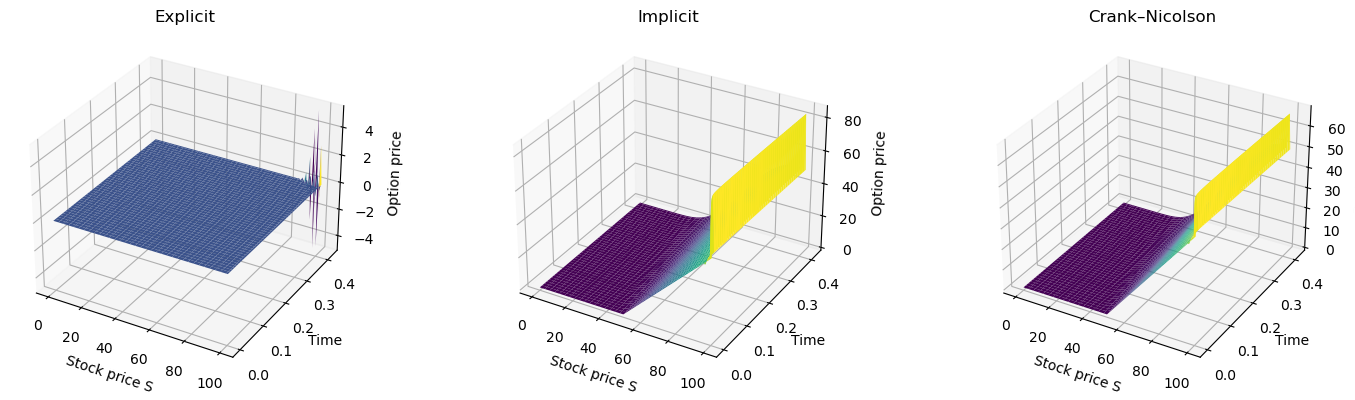

In [5]:
demo_plots(500)

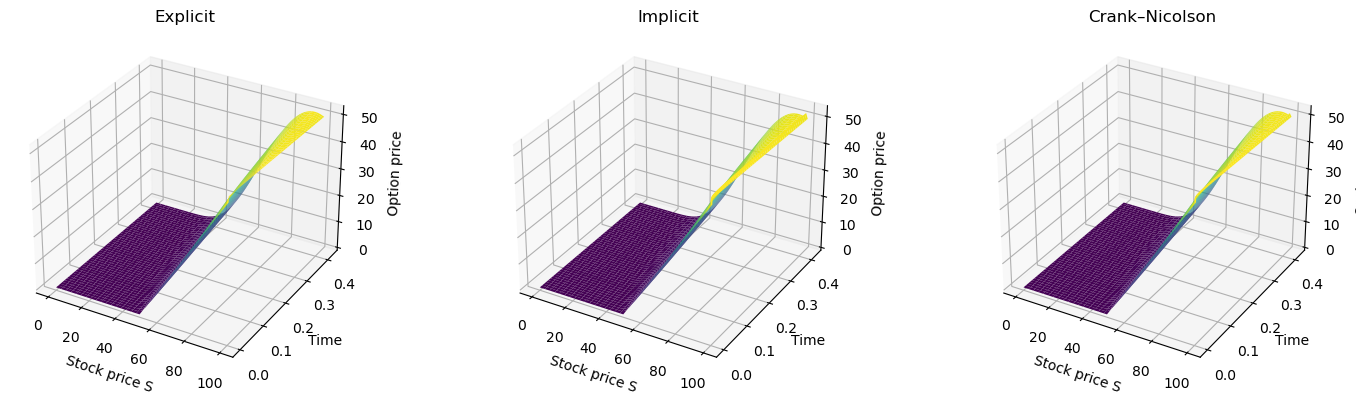

In [6]:
demo_plots(10_000)

In [ ]:
demo_convergence_rms()